In [1]:
import jax
import jax.numpy as jnp 
import flax.linen as nn
import optax
from flax.training.train_state import TrainState

# Fixed Point Iteration as a Layer
Solving the following problem:

$$
z = tanh(W*z + x)
$$

This implicit layer can be represented as a fixed point iteration. 

In [2]:

class TanhFiexedPointLayer(nn.Module):
    out_features: int 
    tol: float = 1e-04 
    max_iter: int = 50 

    @nn.compact
    def __call__(self, x):
        z = jnp.zeros_like(x)
        iter = 0
        linear = nn.Dense(self.out_features, use_bias=False)
        # iterate until convergence
        while iter < self.max_iter:
            z_next = nn.tanh(linear(x) + z)
            error = jnp.linalg.norm(z_next - z)
            z = z_next
            iter += 1  
            if error < self.tol:
                break

        return z, iter, error

In [3]:
layer = TanhFiexedPointLayer(50)
key = jax.random.PRNGKey(1)

x = jax.random.normal(key, (10, 50))

# initialize the parameters
init_params = layer.init(key, jnp.ones((10, 50)))
print(init_params)
# apply the layer
z, iter, err = layer.apply(init_params, x)
z.shape, iter, err

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


FrozenDict({
    params: {
        Dense_0: {
            kernel: Array([[-0.00112402,  0.01049197, -0.1107769 , ...,  0.06686379,
                     0.06641757,  0.15790488],
                   [-0.05339506,  0.17241323, -0.22775021, ..., -0.22635862,
                     0.07368673, -0.18832724],
                   [ 0.16974592, -0.04329657,  0.19627635, ..., -0.03350458,
                    -0.02757894,  0.09015729],
                   ...,
                   [ 0.02844509,  0.22286433,  0.16291836, ...,  0.0094636 ,
                     0.02387309, -0.01765661],
                   [-0.05769478, -0.18182161, -0.02211224, ...,  0.06700245,
                     0.0289749 , -0.1785477 ],
                   [ 0.02784303,  0.05188631,  0.01045604, ..., -0.18541177,
                     0.09383972, -0.3002459 ]], dtype=float32),
        },
    },
})


((10, 50), 50, Array(0.00084512, dtype=float32))

# Differentiation of ODE

In [4]:
from jax.experimental.ode import odeint
from functools import partial


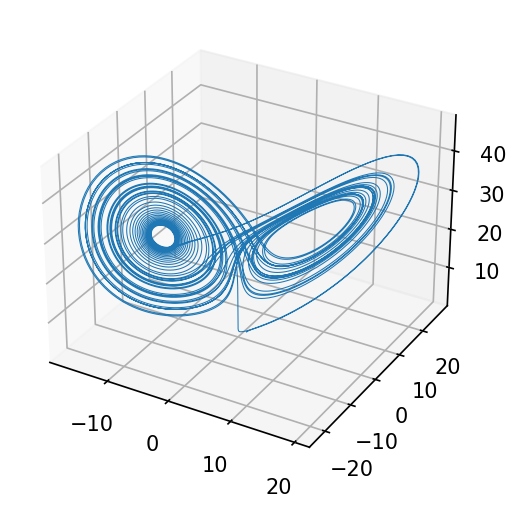

In [5]:
def f(state, t, rho, sigma, beta):
    x, y, z = state 
    return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

f = partial(f, rho=28.0, sigma=10.0, beta=8.0/3.0)
t = jnp.linspace(0, 50, 10000)
state0 = jnp.array([1.0, 1.0, 1.0])

ys = odeint(f, state0, t)

import matplotlib.pyplot as plt

def plot_3d_path(ax, ys, color):
  x0, x1, x2 = ys.T
  ax.plot(x0, x1, x2, lw=0.5, color=color)

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(111, projection='3d')
plot_3d_path(ax, ys, color='C0')

Use the dynamical system to generate training data

In [6]:
train = ys

In [7]:
# create a neural dynamical model
class NeuralDynamics(nn.Module):
    num_states: int = 3

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(3)(x)
        x = nn.relu(x)
        #x = nn.Dense(16)(x)
        #x = nn.relu(x)
        x = nn.Dense(self.num_states)(x)

        return x

dynamics = NeuralDynamics()
key = jax.random.PRNGKey(0)

param_init = dynamics.init(key, state0)

def f(x, t, params):

    return dynamics.apply(params, x) 

print(f(state0, 0, param_init))
y = odeint(f, state0, t, param_init)

[-0.05648135  0.07030777 -0.09987433]


In [8]:
optimizer = optax.chain(
    #optax.clip_by_global_norm(1.0),
    optax.clip(0.01),
    #optax.scale(1.2),
    #optax.lamb(1e-04),
    optax.adam(1e-2)
)

train_state = TrainState.create(
    apply_fn=f, # not used
    params=param_init,
    tx = optimizer,
)

#@jax.jit
def train_step(f, state_init, t, target, train_state):
    def mse_loss(params):
        # prediction
        outputs_pred = odeint(f, state_init, t, params)
        #outputs_pred = jnp.clip(outputs_pred, 16., 40.)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        return pred_loss
    
    loss, grad = jax.value_and_grad(mse_loss)(train_state.params)
    train_state = train_state.apply_gradients(grads=grad)

    return loss, grad, train_state

# train the model
for i in range(400):
    loss, grad, train_state = train_step(f, state0, t, ys, train_state)
    print(loss)

492.1928
314.05273
258.17102
244.52591
240.0722
236.44856
230.36496
224.68669
220.97357
217.43797
213.9489
210.508
207.12497
203.45216
198.98059
193.74828
187.83989
181.32964
174.31314
167.03738
160.92618
156.726
154.27148
154.66557
157.74623
160.53526
161.2188
159.43983
155.93689
151.96513
148.72456
146.88922
146.38768
146.48412
146.47137
146.05977
145.22704
144.1079
142.9444
142.00487
141.40135
140.93529
140.37416
139.60739
138.68163
137.72339
136.86972
136.15318
135.48112
134.75832
134.01068
133.29428
132.59276
131.87288
131.13579
130.40575
129.69618
129.00385
128.32536
127.66673
127.04227
126.46167
125.91818
125.410065
124.9246
124.44456
123.96167
123.469765
122.970055
122.46927
121.963486
121.45721
120.95955
120.59778
120.28369
120.01755
119.8472
119.76285
119.66804
119.52362
119.337
119.13637
118.926346
118.67424
118.36124
117.986404
117.55936
117.10412
116.67217
116.2545
115.79199
115.29402
114.82178
114.362885
113.862976
113.32275
112.79578
112.2683
111.68318
111.06987
110.4952

In [9]:
outputs_pred = odeint(f, state0, t, train_state.params)
outputs_pred

Array([[ 1.        ,  1.        ,  1.        ],
       [ 0.9985231 ,  0.99470085,  1.0560544 ],
       [ 0.9970476 ,  0.9894115 ,  1.1120058 ],
       ...,
       [-3.2999613 , -1.7161499 , 22.133413  ],
       [-3.3003414 , -1.7161812 , 22.132946  ],
       [-3.3007214 , -1.7162124 , 22.13248   ]], dtype=float32)

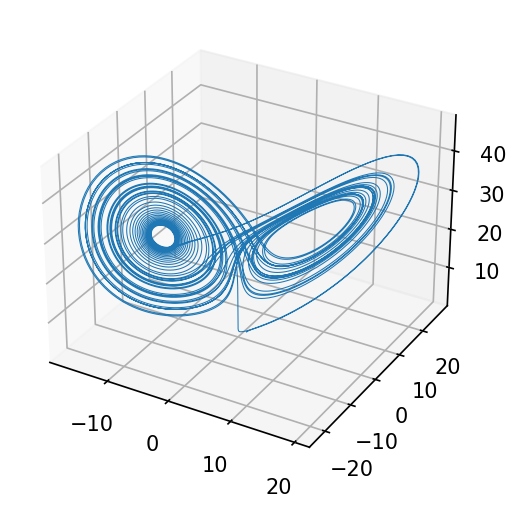

In [10]:
y_preds = odeint(f, state0, t, train_state.params)

# Plot resulting model.
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(111, projection='3d')
plot_3d_path(ax, ys, color='C0')


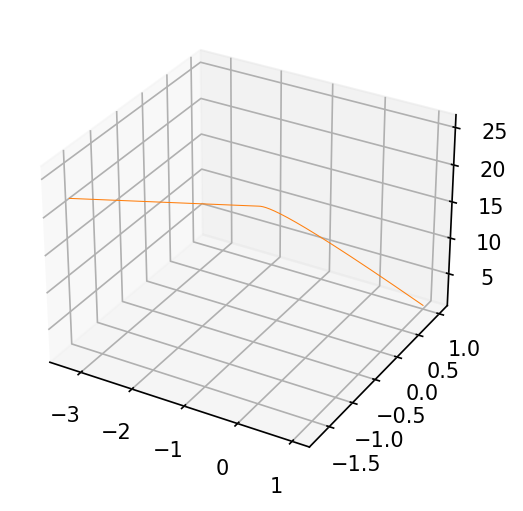

In [11]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(111, projection='3d')
plot_3d_path(ax, y_preds, color='C1')

## Traing with one-step prediction

Apparently, treating the whole trajectory as only one sample, will lead to difficulties during training.

A typical case is to train the model with one-step prediction, this for sure will lead to easier prediction problem. But can that be used for rollout predictions??


In [12]:
# create a neural dynamical model

class NeuralDynamics(nn.Module):
    num_states: int = 3

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(3)(x)
        x = nn.relu(x)
        #x = nn.Dense(16)(x)
        #x = nn.relu(x)
        x = nn.Dense(self.num_states)(x)

        return x

dynamics = NeuralDynamics()
key = jax.random.PRNGKey(0)

param_init = dynamics.init(key, state0)

def f(x, t, params):
    return dynamics.apply(params, x)

def odenet(params, state_init):
    ys = odeint(f, state_init, jnp.array([0., 1.]), params)
    return ys[1,:]

odenet_vmap = jax.vmap(odenet, in_axes=(None, 0))

odenet_vmap(param_init, jnp.vstack([state0, state0]))

Array([[0.9379821 , 1.0715036 , 0.89588195],
       [0.9379821 , 1.0715036 , 0.89588195]], dtype=float32)

In [14]:
optimizer = optax.chain(
    #optax.clip_by_global_norm(1.0),
    optax.clip(0.01),
    #optax.scale(1.2),
    #optax.lamb(1e-04),
    optax.adam(1e-2)
)

train_state = TrainState.create(
    apply_fn=f, # not used
    params=param_init,
    tx = optimizer,
)

#@jax.jit
def train_step(f, state_init, t, target, train_state):
    def mse_loss(params):
        # prediction
        outputs_pred = odeint(f, state_init, t, params)
        #outputs_pred = jnp.clip(outputs_pred, 16., 40.)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        return pred_loss
    
    loss, grad = jax.value_and_grad(mse_loss)(train_state.params)
    train_state = train_state.apply_gradients(grads=grad)

    return loss, grad, train_state

# train the model
x_train = ys[:-1, :]
y_train = ys[1:, :]

batch_size = 256
for epoch in range(10):
    for i in range(x_train.shape[0] // batch_size):
        x_batch = x_train[i*batch_size:(i+1)*batch_size, :]
        y_batch = y_train[i*batch_size:(i+1)*batch_size, :]
        loss, grad, train_state = train_step(f, x_batch, t, y_batch, train_state)
    print(loss)

0.15688358
0.010733201


KeyboardInterrupt: 